    Trying     
    1. Simple RNN
    2. LSTM
    3. GRU
    
    搭建一個 LSTM 的神經網絡，與 CNN 的實戰系列一樣，採用 Keras 作為實作的工具!

In [24]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# multi-factor
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf 

In [116]:
# Import the training set
dataset_train = pd.read_csv('0721.csv')  # 讀取訓練集(OLD)
training_set = pd.DataFrame(dataset_train, columns=['login_date', 'all'])
training_set['login_date'] = pd.to_datetime(training_set['login_date'])

training_set.set_index(["login_date"], inplace=True)

In [117]:
dataset_train.head()
print(training_set[0:5])

                       all
login_date                
2021-11-24 00:00:00  15886
2021-11-24 01:00:00   8958
2021-11-24 02:00:00   5248
2021-11-24 03:00:00   3595
2021-11-24 04:00:00   2982


做 Normalization，將資料壓縮在 [0,1] 之間

In [118]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled[0:5]

array([[0.2511475 ],
       [0.14111462],
       [0.08219113],
       [0.05593761],
       [0.04620174]])

In [119]:
len(training_set_scaled)

4979

切成train&test

In [120]:
X_train = []   #預測點的前 60 hours 的資料
y_train = []   #預測點
for i in range(60, 4000):  # 4000 是訓練集總數
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [121]:
len(X_train)

3940

for test 

In [122]:
X_test = []
for i in range(4000+60, 4979):  
    X_test.append(training_set_scaled[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [123]:
len(X_test)

919

## A、搭建一個 LSTM_model

In [11]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

2022-08-05 11:45:56.999957: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [13]:
# Adding the output layer
# Ouput Layer: units 設為 1
regressor.add(Dense(units = 1))

Compiling & Fitting LSTM model
- optimizer: 選擇 Adam
- loss: 使用 MSE

In [128]:
# Compiling
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 進行訓練
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
124/124 [==============================] - 11s 51ms/step - loss: 0.0429
Epoch 2/100
124/124 [==============================] - 6s 51ms/step - loss: 0.0182
Epoch 3/100
124/124 [==============================] - 6s 52ms/step - loss: 0.0126
Epoch 4/100
124/124 [==============================] - 6s 52ms/step - loss: 0.0103
Epoch 5/100
124/124 [==============================] - 6s 52ms/step - loss: 0.0099
Epoch 6/100
124/124 [==============================] - 7s 53ms/step - loss: 0.0082
Epoch 7/100
124/124 [==============================] - 7s 53ms/step - loss: 0.0076
Epoch 8/100
124/124 [==============================] - 7s 55ms/step - loss: 0.0063
Epoch 9/100
124/124 [==============================] - 7s 55ms/step - loss: 0.0058
Epoch 10/100
124/124 [==============================] - 7s 54ms/step - loss: 0.0058
Epoch 11/100
124/124 [==============================] - 7s 54ms/step - loss: 0.0056
Epoch 12/100
124/124 [==============================] - 7s 56ms/step - loss: 0.0051


    進行預測

In [129]:
real_value = training_set[4060:]

In [130]:
predicted_value = regressor.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)  # to get the original scale
predicted_value[0:5]

array([[36907.438],
       [36053.258],
       [34503.984],
       [31924.197],
       [28710.043]], dtype=float32)

In [131]:
real_value[0:5]

,all
login_date,
2021-06-08 13:00:00,37832
2021-06-08 14:00:00,36486
2021-06-08 15:00:00,34654
2021-06-08 16:00:00,29794
2021-06-08 17:00:00,27697


In [135]:
predicted_value[0:5]

array([[36907.438],
       [36053.258],
       [34503.984],
       [31924.197],
       [28710.043]], dtype=float32)

In [140]:
real_value["prediction"] = predicted_value

/var/folders/tf/7633jhwn4_gfj1fldy8jf5680000gq/T/ipykernel_18012/595127505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_value["prediction"] = predicted_value


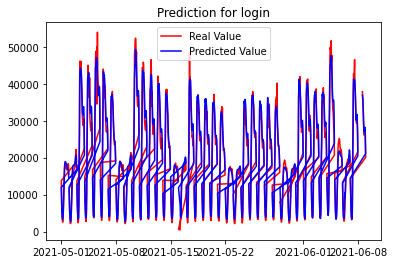

In [143]:
# Visualising the results 
plt.plot(real_value["all"], color = 'red', label = 'Real Value')  # 紅線表示真實
plt.plot(real_value["prediction"], color = 'blue', label = 'Predicted Value')  # 藍線表示預測
plt.title('Prediction for login')
# plt.xlabel('Time')
# plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

## 改時間

先後順序改清楚ㄌ, 再去train! 

In [203]:
dataset_train = pd.read_csv('0727.csv')  # 讀取訓練集
print (dataset_train.loc[dataset_train['login_date'] == '2021-10-01 00:00:00'])

               login_date    all
3664  2021-10-01 00:00:00  18253


In [204]:
len(dataset_train)

4979

In [205]:
dataset_train

,login_date,all
0,2021-05-01 00:00:00,13766
1,2021-05-01 01:00:00,8858
2,2021-05-01 02:00:00,5393
3,2021-05-01 03:00:00,3381
4,2021-05-01 04:00:00,2536
...,...,...
4974,2021-11-24 19:00:00,39665
4975,2021-11-24 20:00:00,33676
4976,2021-11-24 21:00:00,32705
4977,2021-11-24 22:00:00,30271


In [207]:
dataset_train = pd.read_csv('0727.csv')  # 讀取訓練集（OLD)
training_set = pd.DataFrame(dataset_train, columns=['login_date', 'all'])
training_set['login_date'] = pd.to_datetime(training_set['login_date'])

training_set.set_index(["login_date"], inplace=True)

# normalization
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled[0:5]

# training data
X_train = []   #預測點的前 60 hours 的資料
y_train = []   #預測點
for i in range(60, 3664):  # 後者訓練集總數
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# testing data
X_test = []
for i in range(3664+60, 4979):  
    X_test.append(training_set_scaled[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [208]:
len(X_train), len(X_test)

(3604, 1255)

In [210]:
# 進行訓練
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
113/113 [==============================] - 7s 60ms/step - loss: 0.0015
Epoch 2/100
113/113 [==============================] - 7s 61ms/step - loss: 0.0014
Epoch 3/100
113/113 [==============================] - 7s 59ms/step - loss: 0.0013
Epoch 4/100
113/113 [==============================] - 6s 52ms/step - loss: 0.0013
Epoch 5/100
113/113 [==============================] - 6s 54ms/step - loss: 0.0012
Epoch 6/100
113/113 [==============================] - 6s 56ms/step - loss: 0.0012
Epoch 7/100
113/113 [==============================] - 6s 57ms/step - loss: 0.0012
Epoch 8/100
113/113 [==============================] - 6s 55ms/step - loss: 0.0012
Epoch 9/100
113/113 [==============================] - 7s 60ms/step - loss: 0.0011
Epoch 10/100
113/113 [==============================] - 7s 61ms/step - loss: 0.0011
Epoch 11/100
113/113 [==============================] - 7s 62ms/step - loss: 0.0011
Epoch 12/100
113/113 [==============================] - 7s 66ms/step - loss: 0.0011
E

113/113 [==============================] - 7s 62ms/step - loss: 7.3002e-04
Epoch 96/100
113/113 [==============================] - 7s 62ms/step - loss: 8.0279e-04
Epoch 97/100
113/113 [==============================] - 7s 61ms/step - loss: 7.4461e-04
Epoch 98/100
113/113 [==============================] - 6s 57ms/step - loss: 7.3127e-04
Epoch 99/100
113/113 [==============================] - 7s 63ms/step - loss: 7.2335e-04
Epoch 100/100
113/113 [==============================] - 8s 74ms/step - loss: 7.3118e-04


In [217]:
print(training_set[3664+60 : 3664+60+5])

predicted_value = regressor.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value) 
print(predicted_value[0:5])

                       all
login_date                
2021-10-03 12:00:00  18673
2021-10-03 13:00:00  18521
2021-10-03 14:00:00  18720
2021-10-03 15:00:00  18960
2021-10-03 16:00:00  19708
[[18272.178]
 [18452.611]
 [18585.3  ]
 [18648.857]
 [18448.389]]


In [219]:
real_value = training_set[3664+60 :]

predicted_value = regressor.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)  # to get the original scale
real_value["prediction"] = predicted_value


/var/folders/tf/7633jhwn4_gfj1fldy8jf5680000gq/T/ipykernel_18012/3439371161.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_value["prediction"] = predicted_value


In [220]:
real_value

,all,prediction
login_date,,
2021-10-03 12:00:00,18673,18272.177734
2021-10-03 13:00:00,18521,18452.611328
2021-10-03 14:00:00,18720,18585.300781
2021-10-03 15:00:00,18960,18648.857422
2021-10-03 16:00:00,19708,18448.388672
...,...,...
2021-11-24 19:00:00,39665,36987.871094
2021-11-24 20:00:00,33676,39367.578125
2021-11-24 21:00:00,32705,32504.138672


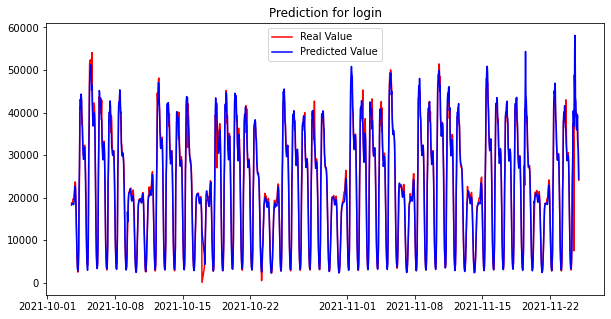

In [228]:
# Visualising the results 
plt.figure(figsize=(10,5))

plt.plot(real_value["all"], color = 'red', label = 'Real Value')  # 紅線表示真實
plt.plot(real_value["prediction"], color = 'blue', label = 'Predicted Value')  # 藍線表示預測
plt.title('Prediction for login')
plt.legend()
plt.show()

In [82]:
import sklearn.metrics as metrics

def timeseries_evaluation_metrics_func(y_true, y_pred):
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n') 
     
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [236]:
timeseries_evaluation_metrics_func(real_value["all"], real_value["prediction"])

Evaluation metric results:-
MSE is : 4268337.547406417
MAE is : 1171.961360806773
RMSE is : 2065.995534217443
MAPE is : 19.47272500254039
R2 is : 0.9752109206104114



In [263]:
fliter = (real_value["diff_%"] < 100)
real_value = real_value[fliter]

In [264]:
timeseries_evaluation_metrics_func(real_value["all"], real_value["prediction"])

Evaluation metric results:-
MSE is : 3466838.5534559363
MAE is : 1140.0658169584915
RMSE is : 1861.944830937785
MAPE is : 5.821117647507868
R2 is : 0.9797917922701104



### 變成有價值的事物1
判斷錯誤率

In [245]:
real_value['diff'] = abs(real_value['all'] - real_value['prediction'])
real_value['diff_%'] = real_value['diff']/ real_value['all']*100

/var/folders/tf/7633jhwn4_gfj1fldy8jf5680000gq/T/ipykernel_18012/2186357846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_value['diff'] = abs(real_value['all'] - real_value['prediction'])
/var/folders/tf/7633jhwn4_gfj1fldy8jf5680000gq/T/ipykernel_18012/2186357846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_value['diff_%'] = real_value['diff']/ real_value['all']*100


In [246]:
real_value

,all,prediction,diff,diff_%
login_date,,,,
2021-10-03 12:00:00,18673,18272.177734,400.822266,2.146534
2021-10-03 13:00:00,18521,18452.611328,68.388672,0.369249
2021-10-03 14:00:00,18720,18585.300781,134.699219,0.719547
2021-10-03 15:00:00,18960,18648.857422,311.142578,1.641047
2021-10-03 16:00:00,19708,18448.388672,1259.611328,6.391371
...,...,...,...,...
2021-11-24 19:00:00,39665,36987.871094,2677.128906,6.749348
2021-11-24 20:00:00,33676,39367.578125,5691.578125,16.900992
2021-11-24 21:00:00,32705,32504.138672,200.861328,0.614161


In [253]:
# 取出差別大於10％的
fliter = (real_value["diff_%"] > 10)
real_value[fliter]

,all,prediction,diff,diff_%
login_date,,,,
2021-10-04 04:00:00,2496,2823.898193,327.898193,13.136947
2021-10-04 05:00:00,3163,4044.943604,881.943604,27.883136
2021-10-04 07:00:00,18373,22413.435547,4040.435547,21.991158
2021-10-04 23:00:00,26232,23078.691406,3153.308594,12.020847
2021-10-05 00:00:00,20516,16473.818359,4042.181641,19.702582
...,...,...,...,...
2021-11-24 11:00:00,7501,36995.433594,29494.433594,393.206687
2021-11-24 12:00:00,48877,36780.496094,12096.503906,24.748867
2021-11-24 13:00:00,44977,54664.089844,9687.089844,21.537875


In [255]:
len(real_value[fliter])

183

In [257]:
print("預估錯誤率:", len(real_value[fliter])/len(real_value))

預估錯誤率: 0.14581673306772908


印出找異常值

In [261]:
fliter = (real_value["diff_%"] > 100)
real_value[fliter]

,all,prediction,diff,diff_%
login_date,,,,
2021-10-17 00:00:00,73,11999.765625,11926.765625,16338.035103
2021-10-23 04:00:00,484,2511.905762,2027.905762,418.988794
2021-11-24 11:00:00,7501,36995.433594,29494.433594,393.206687


### 變成有價值的事物2
設定threshold=10k

In [288]:
real_value = training_set[3664+60 :]

predicted_value = regressor.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)  # to get the original scale
real_value["prediction"] = predicted_value

real_value.head()

/var/folders/tf/7633jhwn4_gfj1fldy8jf5680000gq/T/ipykernel_18012/3175271832.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_value["prediction"] = predicted_value


,all,prediction
login_date,,
2021-10-03 12:00:00,18673,18272.177734
2021-10-03 13:00:00,18521,18452.611328
2021-10-03 14:00:00,18720,18585.300781
2021-10-03 15:00:00,18960,18648.857422
2021-10-03 16:00:00,19708,18448.388672


In [289]:
value2 = real_value
# del value2["diff_%"]
threshold = 10000

value2["all"] = value2["all"].apply( lambda x : True if (x > threshold) else False)
value2["prediction"] = value2["prediction"].apply( lambda x : True if (x > threshold) else False)


/var/folders/tf/7633jhwn4_gfj1fldy8jf5680000gq/T/ipykernel_18012/4033940241.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value2["all"] = value2["all"].apply( lambda x : True if (x > threshold) else False)
/var/folders/tf/7633jhwn4_gfj1fldy8jf5680000gq/T/ipykernel_18012/4033940241.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value2["prediction"] = value2["prediction"].apply( lambda x : True if (x > threshold) else False)


In [290]:
value2

,all,prediction
login_date,,
2021-10-03 12:00:00,True,True
2021-10-03 13:00:00,True,True
2021-10-03 14:00:00,True,True
2021-10-03 15:00:00,True,True
2021-10-03 16:00:00,True,True
...,...,...
2021-11-24 19:00:00,True,True
2021-11-24 20:00:00,True,True
2021-11-24 21:00:00,True,True


一樣印出錯誤結果去看～

In [294]:
fliter = (real_value["all"] != real_value["prediction"] )
real_value[fliter]

,all,prediction
login_date,,
2021-10-06 06:00:00,True,False
2021-10-08 01:00:00,True,False
2021-10-08 06:00:00,True,False
2021-10-09 01:00:00,True,False
2021-10-10 01:00:00,True,False
2021-10-13 01:00:00,True,False
2021-10-15 06:00:00,True,False
2021-10-16 01:00:00,True,False
2021-10-16 07:00:00,False,True


In [295]:
len(real_value[fliter])

22

In [316]:
real_value['jam'] = (real_value["all"]==True) & (real_value["prediction"]==False)

/var/folders/tf/7633jhwn4_gfj1fldy8jf5680000gq/T/ipykernel_18012/3356509996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_value['jam'] = (real_value["all"]==True) & (real_value["prediction"]==False)


In [318]:
fliter = (real_value["jam"] == True )
real_value[fliter]

,all,prediction,jam
login_date,,,
2021-10-06 06:00:00,True,False,True
2021-10-08 01:00:00,True,False,True
2021-10-08 06:00:00,True,False,True
2021-10-09 01:00:00,True,False,True
2021-10-10 01:00:00,True,False,True
2021-10-13 01:00:00,True,False,True
2021-10-15 06:00:00,True,False,True
2021-10-16 01:00:00,True,False,True
2021-10-17 08:00:00,True,False,True


In [319]:
len(real_value[fliter])

17

-> 這是我預測：應該不會塞車，但塞車的機率<br>
-> 17次！

In [324]:
print("讓網頁shutdown的可能: ", (len(real_value[fliter])/len(real_value)))

讓網頁shutdown的可能:  0.013545816733067729


## B、加入特徵去train_model 

In [447]:
data = pd.read_csv("0727_ver2.csv")
data.head()

,Unnamed: 0,login_date,hour,all,Dollar,RMB,EUR/ Dollar,Taiwan_stock,markup_2,number_version,weekend_or_not,day,payday
0,4955,2021-05-01 00:00:00,0,13766,27.95,4.325011,1.21205,17566.66,0.0,6,1,1,0
1,4956,2021-05-01 01:00:00,1,8858,27.95,4.325011,1.21205,17566.66,0.0,6,1,1,0
2,4957,2021-05-01 02:00:00,2,5393,27.95,4.325011,1.21205,17566.66,0.0,6,1,1,0
3,4958,2021-05-01 03:00:00,3,3381,27.95,4.325011,1.21205,17566.66,0.0,6,1,1,0
4,4959,2021-05-01 04:00:00,4,2536,27.95,4.325011,1.21205,17566.66,0.0,6,1,1,0


In [449]:
for i in data.select_dtypes('object').columns:
    le = preprocessing.LabelEncoder().fit(data[i])
    data[i] = le.transform(data[i]) 
    
    X_scaler = MinMaxScaler()
    Y_scaler = MinMaxScaler()
    
    X_data = X_scaler.fit_transform(data[['hour', 'day', 'Dollar', 'RMB', 'Taiwan_stock', 'markup_2', 'number_version',
        'weekend_or_not', 'payday','all']])
    Y_data = Y_scaler.fit_transform(data[['all']])

In [450]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i - window, i)
        X.append(dataset[indices])
        indicey = range(i + 1, i + 1 + horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y) 

In [451]:
hist_window = 48
horizon = 10
TRAIN_SPLIT = 4900 #???

x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)


In [452]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])


Multiple window of past history

[[0.         0.         0.61228407 0.45165728 0.82556803 0.4433657
  0.83333333 1.         0.         0.21747693]
 [0.04347826 0.         0.61228407 0.45165728 0.82556803 0.4433657
  0.83333333 1.         0.         0.13952639]
 [0.08695652 0.         0.61228407 0.45165728 0.82556803 0.4433657
  0.83333333 1.         0.         0.08449407]
 [0.13043478 0.         0.61228407 0.45165728 0.82556803 0.4433657
  0.83333333 1.         0.         0.05253879]
 [0.17391304 0.         0.61228407 0.45165728 0.82556803 0.4433657
  0.83333333 1.         0.         0.03911821]
 [0.2173913  0.         0.61228407 0.45165728 0.82556803 0.4433657
  0.83333333 1.         0.         0.04415292]
 [0.26086957 0.         0.61228407 0.45165728 0.82556803 0.4433657
  0.83333333 1.         0.         0.07234408]
 [0.30434783 0.         0.61228407 0.45165728 0.82556803 0.4433657
  0.83333333 1.         0.         0.12284993]
 [0.34782609 0.         0.61228407 0.45165728 0.8255680

In [453]:
import tensorflow as tf

In [454]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()


In [340]:
lstm_model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=horizon),
 ])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary() 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 400)          337600    
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 48, 20)            8020      
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 20)                6020      
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dropout_16 (Dropout)        (None, 20)               

Epoch 1/150
100/100 [==============================] - 52s 478ms/step - loss: 0.0407 - val_loss: 0.0398
Epoch 2/150
100/100 [==============================] - 46s 457ms/step - loss: 0.0176 - val_loss: 0.0286
Epoch 3/150
100/100 [==============================] - 45s 454ms/step - loss: 0.0134 - val_loss: 0.0243
Epoch 4/150
100/100 [==============================] - 45s 449ms/step - loss: 0.0115 - val_loss: 0.0195
Epoch 5/150
100/100 [==============================] - 47s 471ms/step - loss: 0.0092 - val_loss: 0.0222
Epoch 6/150
100/100 [==============================] - 50s 503ms/step - loss: 0.0083 - val_loss: 0.0249
Epoch 7/150
100/100 [==============================] - 50s 495ms/step - loss: 0.0087 - val_loss: 0.0219
Epoch 8/150
100/100 [==============================] - 51s 506ms/step - loss: 0.0080 - val_loss: 0.0212
Epoch 9/150
100/100 [==============================] - 50s 499ms/step - loss: 0.0066 - val_loss: 0.0186
Epoch 10/150
100/100 [==============================] - 50s 504m

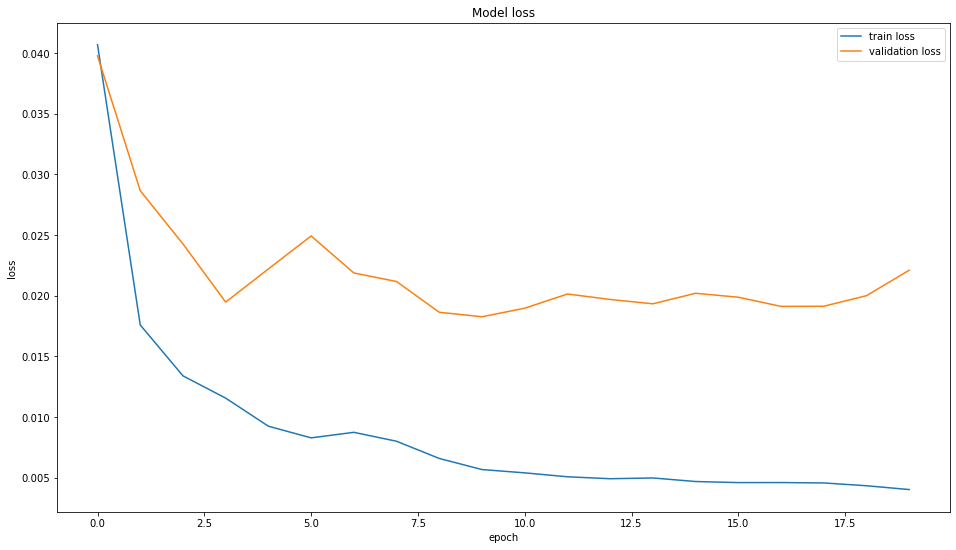

In [341]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks = [early_stopings,checkpoint] 

history = lstm_model.fit(train_data,epochs=150,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

# print model result
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

去驗證

In [455]:
tmp = data[['hour', 'day', 'Dollar', 'RMB', 'Taiwan_stock', 'markup_2', 'number_version',
        'weekend_or_not', 'payday','all']].tail(48+10)
tmp2 = tmp[:-10]
actual = tmp["all"][-10:]

In [456]:
tmp

,hour,day,Dollar,RMB,Taiwan_stock,markup_2,number_version,weekend_or_not,payday,all
4921,14,22,27.783,4.353263,17803.54,-0.8,1,0,0,38562
4922,15,22,27.783,4.353263,17803.54,-0.8,1,0,0,37352
4923,16,22,27.783,4.353263,17803.54,-0.8,1,0,0,32977
4924,17,22,27.783,4.353263,17803.54,-0.8,1,0,0,30671
4925,18,22,27.783,4.353263,17803.54,-0.8,1,0,0,29135
4926,19,22,27.783,4.353263,17803.54,-0.8,1,0,0,29595
4927,20,22,27.783,4.353263,17803.54,-0.8,1,0,0,30377
4928,21,22,27.783,4.353263,17803.54,-0.8,1,0,0,30207
4929,22,22,27.783,4.353263,17803.54,-0.8,1,0,0,28224
4930,23,22,27.783,4.353263,17803.54,-0.8,1,0,0,22738


In [457]:
list(actual)

[43175, 41295, 39105, 39997, 38695, 39665, 33676, 32705, 30271, 24091]

In [458]:
len(tmp2)

48

forecast the 10 hrs after input data

In [465]:
# tmp2是還沒轉換前的預測值
# 由前48小時預測後10個小時
data_val = X_scaler.fit_transform(tmp2)

val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse 

array([[28576.389, 27660.068, 26907.26 , 27720.748, 28377.586, 30900.094,
        30573.98 , 28320.426, 23892.736, 19136.812]], dtype=float32)

In [462]:
print(data_val.shape)
print(val_rescaled.shape)
print(pred.shape)

(48, 10)
(1, 48, 10)
(1, 10)


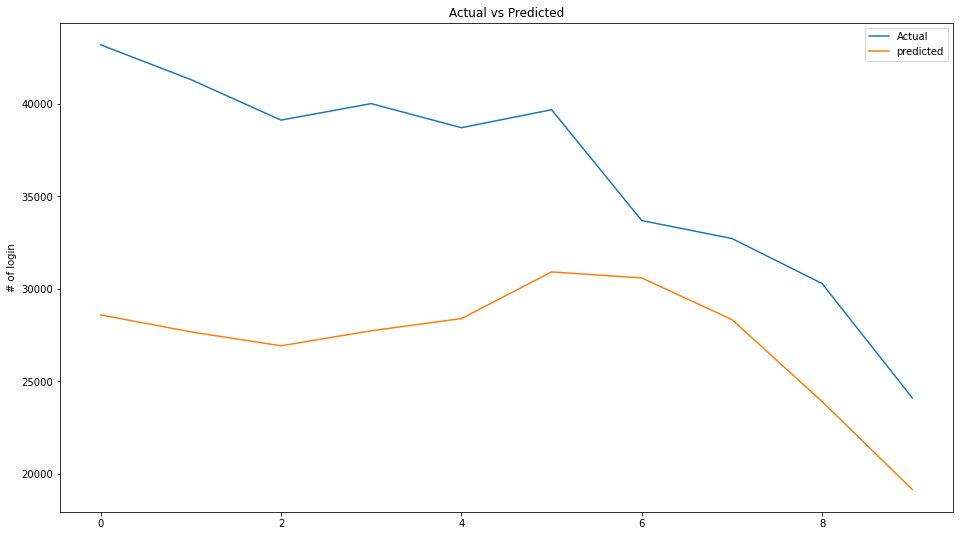

In [464]:
# result 
plt.figure(figsize=(16,9))
# plt.plot( list(validate['all']))
plt.plot( list(actual))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("# of login")
plt.legend(('Actual','predicted'))
plt.show() 

In [475]:
a = list(actual)
b = list(pred_Inverse[0])
print(len(a))
print(len(b))

10
10


In [479]:
timeseries_evaluation_metrics_func(list(actual), list(pred_Inverse[0]))

Evaluation metric results:-
MSE is : 97586789.44095345
MAE is : 9060.8900390625
RMSE is : 9878.602605680291
MAPE is : 24.172979461382127
R2 is : -2.0880127163399957



In [481]:
mean_absolute_percentage_error(list(actual), list(pred_Inverse[0]))

24.172979461382127

    趨勢是對的？？？
    但數值很奇怪？？
    --> 不用加入特徵版本的

## C、加入最終版本的 Data(1年)

In [515]:
dataset_train = pd.read_csv('0728.csv')  # 讀取訓練集
dataset_train.head()

training_set = pd.DataFrame(dataset_train, columns=['登入日期', '登入時間(以小時為單位)', '登入成功次數'])
training_set.head()

# 時間處理
training_set['login_date'] = training_set['登入日期'].astype('str')
training_set['hour'] = training_set['登入時間(以小時為單位)'].astype('str')
training_set['login_date'] = training_set['login_date'] + " " + training_set['hour'] + ":00:00"
training_set['login_date'] = pd.to_datetime(training_set['login_date'])

del training_set['登入日期']
del training_set['hour']
del training_set['登入時間(以小時為單位)']

# training_set.set_index(["login_date"], inplace=True)
# training_set.head()

In [516]:
training_set.head()

,登入成功次數,login_date
0,20722,2021-10-01 00:00:00
1,11342,2021-10-01 01:00:00
2,6698,2021-10-01 02:00:00
3,4633,2021-10-01 03:00:00
4,3611,2021-10-01 04:00:00


In [517]:
training_set.loc[training_set['login_date'] == '2022-05-01 00:00:00']

,登入成功次數,login_date
7993,19182,2022-05-01


In [496]:
len(training_set)

9453

In [518]:
training_set.set_index(["login_date"], inplace=True)
training_set.head()

,登入成功次數
login_date,
2021-10-01 00:00:00,20722
2021-10-01 01:00:00,11342
2021-10-01 02:00:00,6698
2021-10-01 03:00:00,4633
2021-10-01 04:00:00,3611


In [519]:
training_set.tail(60)

,登入成功次數
login_date,
2022-06-07 12:00:00,57359
2022-06-07 13:00:00,55622
2022-06-07 14:00:00,49660
2022-06-07 15:00:00,51179
2022-06-07 16:00:00,45780
2022-06-07 17:00:00,44069
2022-06-07 18:00:00,38592
2022-06-07 19:00:00,38782
2022-06-07 20:00:00,39689


In [14]:
# normalization
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled[0:5]

# training data
X_train = []   #預測點的前 60 hours 的資料
y_train = []   #預測點
for i in range(60, 7993):  # 後者訓練集總數
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# testing data
X_test = []
for i in range(7993+60, 9453):  
    X_test.append(training_set_scaled[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

print(len(X_train), len(X_test))

7933 1400


In [17]:
len(X_train[0])

60

In [521]:
# 進行訓練

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
248/248 [==============================] - 18s 71ms/step - loss: 0.0012
Epoch 2/100
248/248 [==============================] - 15s 59ms/step - loss: 0.0011
Epoch 3/100
248/248 [==============================] - 15s 59ms/step - loss: 0.0011
Epoch 4/100
248/248 [==============================] - 16s 63ms/step - loss: 0.0011
Epoch 5/100
248/248 [==============================] - 18s 72ms/step - loss: 0.0011
Epoch 6/100
248/248 [==============================] - 17s 70ms/step - loss: 0.0010
Epoch 7/100
248/248 [==============================] - 18s 73ms/step - loss: 0.0010
Epoch 8/100
248/248 [==============================] - 16s 65ms/step - loss: 0.0010
Epoch 9/100
248/248 [==============================] - 18s 73ms/step - loss: 0.0010
Epoch 10/100
248/248 [==============================] - 17s 67ms/step - loss: 9.8128e-04
Epoch 11/100
248/248 [==============================] - 17s 67ms/step - loss: 9.8351e-04
Epoch 12/100
248/248 [==============================] - 16s 64ms/s

In [576]:
predicted_value = regressor.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value) 
print(predicted_value[0:5])

print(len(predicted_value))

[[54294.168]
 [51227.918]
 [47979.055]
 [46920.43 ]
 [40510.492]]
1400


In [646]:
# 真實值
real_value = training_set[7993+60:]
real_value["prediction"] = predicted_value

/var/folders/tf/7633jhwn4_gfj1fldy8jf5680000gq/T/ipykernel_18012/4272358877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_value["prediction"] = predicted_value


In [647]:
real_value = real_value.rename(columns = {'登入成功次數':'all'})

real_value

,all,prediction
login_date,,
2022-05-11 12:00:00,51486,54294.167969
2022-05-11 13:00:00,51291,51227.917969
2022-05-11 14:00:00,45712,47979.054688
2022-05-11 15:00:00,46111,46920.429688
2022-05-11 16:00:00,42080,40510.492188
...,...,...
2022-06-09 19:00:00,37260,36382.148438
2022-06-09 20:00:00,38323,36385.179688
2022-06-09 21:00:00,38725,36665.074219


In [539]:
real_value["all"]

login_date
2022-05-11 12:00:00    51486
2022-05-11 13:00:00    51291
2022-05-11 14:00:00    45712
2022-05-11 15:00:00    46111
2022-05-11 16:00:00    42080
                       ...  
2022-06-09 19:00:00    37260
2022-06-09 20:00:00    38323
2022-06-09 21:00:00    38725
2022-06-09 22:00:00    35682
2022-06-09 23:00:00    29748
Name: all, Length: 1400, dtype: int64

In [538]:
real_value["prediction"]

login_date
2022-05-11 12:00:00    54294.167969
2022-05-11 13:00:00    51227.917969
2022-05-11 14:00:00    47979.054688
2022-05-11 15:00:00    46920.429688
2022-05-11 16:00:00    40510.492188
                           ...     
2022-06-09 19:00:00    36382.148438
2022-06-09 20:00:00    36385.179688
2022-06-09 21:00:00    36665.074219
2022-06-09 22:00:00    34611.214844
2022-06-09 23:00:00    27602.642578
Name: prediction, Length: 1400, dtype: float32

In [532]:
len(real_value)

1400

In [609]:
real_value.head()

,all,prediction
login_date,,
2022-05-11 12:00:00,51486,54294.167969
2022-05-11 13:00:00,51291,51227.917969
2022-05-11 14:00:00,45712,47979.054688
2022-05-11 15:00:00,46111,46920.429688
2022-05-11 16:00:00,42080,40510.492188


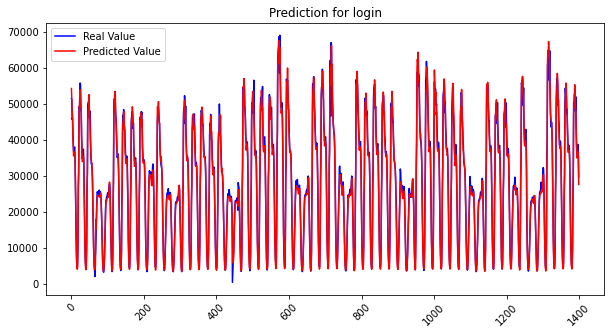

In [611]:
# Visualising the results 
plt.figure(figsize=(10,5))

plt.plot(list(real_value["all"]), color = 'blue', label = 'Real Value')  # 紅線表示真實
plt.plot(list(real_value["prediction"]), color = 'red', label = 'Predicted Value')  # 藍線表示預測
plt.title('Prediction for login')

plt.xticks(rotation=45)
# plt.xticks(range(0, len(real_value), 30), rotation = 90) #???
# plt.xlabel('Time')
# plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


In [580]:
timeseries_evaluation_metrics_func(real_value["all"], real_value["prediction"])


Evaluation metric results:-
MSE is : 3397406.9802274937
MAE is : 1249.8027286202566
RMSE is : 1843.2056261381945
MAPE is : 8.14174742172037
R2 is : 0.9871247781633076



In [628]:
real_value.head()

,all,prediction
login_date,,
2022-05-11 12:00:00,51486,54294.167969
2022-05-11 13:00:00,51291,51227.917969
2022-05-11 14:00:00,45712,47979.054688
2022-05-11 15:00:00,46111,46920.429688
2022-05-11 16:00:00,42080,40510.492188


<AxesSubplot:xlabel='login_date'>

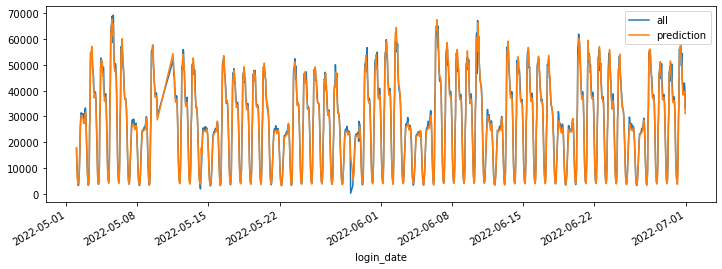

In [642]:
real_value.plot(figsize=(12, 4))

In [631]:
real_value

,all,prediction
login_date,,
2022-05-11 12:00:00,51486,54294.167969
2022-05-11 13:00:00,51291,51227.917969
2022-05-11 14:00:00,45712,47979.054688
2022-05-11 15:00:00,46111,46920.429688
2022-05-11 16:00:00,42080,40510.492188
...,...,...
2022-06-09 19:00:00,37260,36382.148438
2022-06-09 20:00:00,38323,36385.179688
2022-06-09 21:00:00,38725,36665.074219


In [639]:
real_value.head(50)

,all,prediction
login_date,,
2022-05-11 12:00:00,51486,54294.167969
2022-05-11 13:00:00,51291,51227.917969
2022-05-11 14:00:00,45712,47979.054688
2022-05-11 15:00:00,46111,46920.429688
2022-05-11 16:00:00,42080,40510.492188
2022-05-11 17:00:00,39104,38292.285156
2022-05-11 18:00:00,36946,35543.468750
2022-05-11 19:00:00,36529,36597.144531
2022-05-11 20:00:00,37639,35986.746094


array([<AxesSubplot:xlabel='login_date'>,
       <AxesSubplot:xlabel='login_date'>], dtype=object)

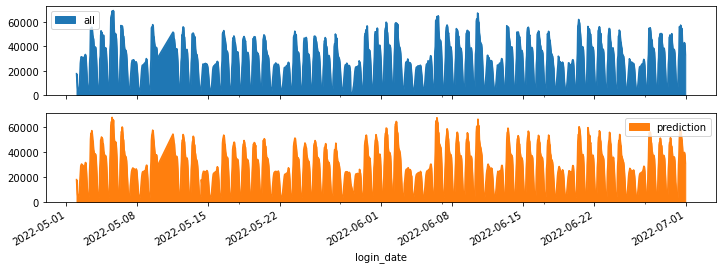

In [648]:
real_value.plot.area(figsize=(12, 4), subplots=True)

### 評估1: threshold 開 10000

In [668]:
len(real_value)

1400

In [669]:
value2 = real_value
# del value2["diff_%"]
threshold = 10000 

value2["all"] = value2["all"].apply( lambda x : True if (x > threshold) else False)
value2["prediction"] = value2["prediction"].apply( lambda x : True if (x > threshold) else False)
value2.head()


,all,prediction,diff,diff_%
login_date,,,,
2022-05-11 12:00:00,True,True,2808.167969,5.454236
2022-05-11 13:00:00,True,True,63.082031,0.122988
2022-05-11 14:00:00,True,True,2267.054688,4.959430
2022-05-11 15:00:00,True,True,809.429688,1.755394
2022-05-11 16:00:00,True,True,1569.507812,3.729819


#### a. 沒有預測正確

In [677]:
fliter = (value2["all"] != value2["prediction"] )
value2[fliter]

,all,prediction,diff,diff_%,jam
login_date,,,,,
2022-05-14 07:00:00,False,True,8458.347656,89.772316,False
2022-05-15 01:00:00,True,False,1078.897461,10.183081,True
2022-05-19 06:00:00,False,True,415.199219,4.188854,False
2022-05-29 00:00:00,False,True,14446.555664,3666.638493,False
2022-05-29 08:00:00,True,False,2307.321289,20.555201,True
2022-06-27 06:00:00,False,True,726.330078,7.688473,False
2022-06-09 06:00:00,True,False,674.709961,6.590895,True


In [678]:
len(value2[fliter])

7

In [679]:
print("以threshold預測不準的數量:", len(value2[fliter]))
print()
print("預估錯誤率:", len(value2[fliter])/len(value2)*100, "%")

以threshold預測不準的數量: 7

預估錯誤率: 0.5 %


#### b. 沒有預測正確

In [673]:
value2['jam'] = (value2["all"]==True) & (value2["prediction"]==False

In [674]:
value2

,all,prediction,diff,diff_%,jam
login_date,,,,,
2022-05-11 12:00:00,True,True,2808.167969,5.454236,False
2022-05-11 13:00:00,True,True,63.082031,0.122988,False
2022-05-11 14:00:00,True,True,2267.054688,4.959430,False
2022-05-11 15:00:00,True,True,809.429688,1.755394,False
2022-05-11 16:00:00,True,True,1569.507812,3.729819,False
...,...,...,...,...,...
2022-06-09 19:00:00,True,True,877.851562,2.356016,False
2022-06-09 20:00:00,True,True,1937.820312,5.056546,False
2022-06-09 21:00:00,True,True,2059.925781,5.319369,False


In [675]:
fliter = (value2["jam"] == True)
value2[fliter]

,all,prediction,diff,diff_%,jam
login_date,,,,,
2022-05-15 01:00:00,True,False,1078.897461,10.183081,True
2022-05-29 08:00:00,True,False,2307.321289,20.555201,True
2022-06-09 06:00:00,True,False,674.709961,6.590895,True


In [676]:
print("以threshold預測失誤的數量:", len(value2[fliter]))
print()
print("預估錯誤率:", len(value2[fliter])/len(value2)*100, "%")

以threshold預測失誤的數量: 3

預估錯誤率: 0.2142857142857143 %


## D、ALL! 

In [11]:
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
%matplotlib inline


Many to many
- Input: sequence vector (Ex: 一週股價)
- Output: sequence vector (Ex: 下週股價)

使用情境：
1. 股價預測：用當週五天股價預測下週五天股價
2. 翻譯：給定一句話，進行翻譯，並回覆另一句翻譯完的文字

In [46]:
# 針對資料進行Normalize
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm

# 將資料整理成參考前五天資料，並預測下一天股價 (Many to one)
def train_windows(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["y"]))
    return np.array(X_train), np.array(Y_train)

# 主要使用兩層lstm以及兩層dense進行預測
def lstm_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='linear'))
    model.add(Dense(1))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

In [28]:
training_set.head()

,登入成功次數,login_date
2203,18443,2021-06-01 00:00:00
2204,10971,2021-06-01 01:00:00
2205,6590,2021-06-01 02:00:00
2206,4511,2021-06-01 03:00:00
2207,3518,2021-06-01 04:00:00


In [43]:
dataset_train = pd.read_csv('0728.csv')  # 讀取訓練集

dataset_train.head()
training_set = pd.DataFrame(dataset_train, columns=['登入日期', '登入時間(以小時為單位)', '登入成功次數'])
training_set.head()

# 時間處理
training_set['login_date'] = training_set['登入日期'].astype('str')
training_set['hour'] = training_set['登入時間(以小時為單位)'].astype('str')
training_set['login_date'] = training_set['login_date'] + " " + training_set['hour'] + ":00:00"
training_set['login_date'] = pd.to_datetime(training_set['login_date'])
training_set = training_set.sort_values(by=['login_date'])

training_set['login_date'] = training_set['login_date'].astype('str')
training_set['登入成功次數'] = training_set['登入成功次數'].astype('int')

del training_set['登入日期']
del training_set['hour']
del training_set['登入時間(以小時為單位)']

# training_set.set_index(["login_date"], inplace=True)
# training_set.head()

training_set

,登入成功次數,login_date
2203,18443,2021-06-01 00:00:00
2204,10971,2021-06-01 01:00:00
2205,6590,2021-06-01 02:00:00
2206,4511,2021-06-01 03:00:00
2207,3518,2021-06-01 04:00:00
...,...,...
9304,40688,2022-06-30 19:00:00
9305,41883,2022-06-30 20:00:00
9306,42954,2022-06-30 21:00:00
9307,41035,2022-06-30 22:00:00


In [44]:
for i in range(60):
    name = "-"+str(i)
    training_set[name] = training_set['登入成功次數'].shift(i)


In [45]:
training_set

,登入成功次數,login_date,-0,-1,-2,-3,-4,-5,-6,-7,...,-50,-51,-52,-53,-54,-55,-56,-57,-58,-59
2203,18443,2021-06-01 00:00:00,18443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2204,10971,2021-06-01 01:00:00,10971,18443.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2205,6590,2021-06-01 02:00:00,6590,10971.0,18443.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2206,4511,2021-06-01 03:00:00,4511,6590.0,10971.0,18443.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2207,3518,2021-06-01 04:00:00,3518,4511.0,6590.0,10971.0,18443.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9304,40688,2022-06-30 19:00:00,40688,39587.0,41682.0,43802.0,54486.0,49569.0,56198.0,57224.0,...,41009.0,43955.0,50380.0,44531.0,48825.0,50377.0,49210.0,47183.0,46808.0,30733.0
9305,41883,2022-06-30 20:00:00,41883,40688.0,39587.0,41682.0,43802.0,54486.0,49569.0,56198.0,...,37183.0,41009.0,43955.0,50380.0,44531.0,48825.0,50377.0,49210.0,47183.0,46808.0
9306,42954,2022-06-30 21:00:00,42954,41883.0,40688.0,39587.0,41682.0,43802.0,54486.0,49569.0,...,38186.0,37183.0,41009.0,43955.0,50380.0,44531.0,48825.0,50377.0,49210.0,47183.0
9307,41035,2022-06-30 22:00:00,41035,42954.0,41883.0,40688.0,39587.0,41682.0,43802.0,54486.0,...,38144.0,38186.0,37183.0,41009.0,43955.0,50380.0,44531.0,48825.0,50377.0,49210.0


In [54]:
training_set = training_set.dropna()
training_set['y'] = training_set['登入成功次數'].shift(-1)
#train = type_result(train)
training_set.iloc[:,3:] = normalize(training_set.iloc[:,3:])
training_set.head()

,登入成功次數,login_date,-0,-1,-2,-3,-4,-5,-6,-7,...,-51,-52,-53,-54,-55,-56,-57,-58,-59,y
2742,39737,2021-06-03 11:00:00,39737,0.503830,0.472327,0.322207,0.272334,0.108031,0.064831,0.047799,...,0.334679,0.220099,0.118916,0.060195,0.043075,0.055484,0.081464,0.136211,0.229584,0.511303
2743,40987,2021-06-03 12:00:00,40987,0.495682,0.503830,0.472327,0.322207,0.272334,0.108031,0.064831,...,0.554541,0.334679,0.220099,0.118916,0.060195,0.043075,0.055484,0.081464,0.136211,0.553778
2744,44386,2021-06-03 13:00:00,44386,0.511303,0.495682,0.503830,0.472327,0.322207,0.272334,0.108031,...,0.590118,0.554541,0.334679,0.220099,0.118916,0.060195,0.043075,0.055484,0.081464,0.518388
2745,41554,2021-06-03 14:00:00,41554,0.553778,0.511303,0.495682,0.503830,0.472327,0.322207,0.272334,...,0.556915,0.590118,0.554541,0.334679,0.220099,0.118916,0.060195,0.043075,0.055484,0.525736
2746,42142,2021-06-03 15:00:00,42142,0.518388,0.553778,0.511303,0.495682,0.503830,0.472327,0.322207,...,0.583070,0.556915,0.590118,0.554541,0.334679,0.220099,0.118916,0.060195,0.043075,0.418105


In [66]:
training_set = training_set.drop(['登入成功次數', 'login_date'], axis=1)


In [69]:
len(training_set)

9393

In [73]:
train = training_set[:9000]
test = training_set[-168:]

In [74]:
len(train), len(test)

(9000, 168)

In [79]:
X_train, Y_train = train_windows(train, 5, 5)
X_test, Y_test = train_windows(test, 5, 5)

In [80]:
model = lstm_stock_model(X_train.shape)
callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=1, mode="auto")
                         

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 256)            324608    
                                                                 
 lstm_3 (LSTM)               (None, 5, 256)            525312    
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 1)             257       
 tributed)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 5)                 0         
                                                                 
 dense_4 (Dense)             (None, 5)                 30        
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                      

In [78]:
history = model.fit(X_train, Y_train, epochs=1000, batch_size=5, validation_split=0.1, callbacks=[callback],shuffle=True)


Epoch 1/1000
1619/1619 [==============================] - 18s 9ms/step - loss: 0.1702 - mean_absolute_error: 0.1702 - val_loss: 0.1788 - val_mean_absolute_error: 0.1788
Epoch 2/1000
1220/1619 [=====================>........] - ETA: 3s - loss: 0.1669 - mean_absolute_error: 0.1669

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:


# training_set['Date'] = pd.to_datetime(training_set['Date'], format='%Y%m%d %H%M%S')
# training_set['weekday'] = training_set['Date'].apply(lambda x: x.day)
# training_set['year'] = training_set['Date'].apply(lambda x: x.year)
# training_set['Month'] = training_set['Date'].apply(lambda x: x.month)
# test = training_set[-30:]
# train = training_set[(train['year']==2017)|((train['year']==2018)&(train['Month']<=3))|((train['year']==2018)&(train['Month']==4)&(train['weekday']<=27))]

# #train & test
# train = train.reset_index()
# test = test.reset_index()
# train = train.dropna()


In [25]:
# normalization
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# training_set_scaled[0:5]

# training data
X_train = []   #預測點的前 60 hours 的資料
y_train = []   #預測點
for i in range(60, 9284):  # 後者訓練集總數
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# testing data
X_test = []
for i in range(9285, 9453):  
    X_test.append(training_set_scaled[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

print(len(X_train), len(X_test))


9224 168


In [10]:
X_train, Y_train = train_windows(X_train, 300, 60)
X_test, Y_test = train_windows(training_set, 300, 60)

NameError: name 'train' is not defined

In [ ]:
history = model.fit(X_train, Y_train, epochs=1000, batch_size=5, validation_split=0.1, callbacks=[callback],shuffle=True)


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


In [ ]:
model = lstm_stock_model(X_train.shape)
callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=1, mode="auto")

In [6]:
import pandas as pd

In [26]:
dataset_train = pd.read_csv('0728.csv')  # 讀取訓練集

dataset_train.head()
training_set = pd.DataFrame(dataset_train, columns=['登入日期', '登入時間(以小時為單位)', '登入成功次數'])
training_set.head()

# 時間處理
training_set['login_date'] = training_set['登入日期'].astype('str')
training_set['hour'] = training_set['登入時間(以小時為單位)'].astype('str')
training_set['login_date'] = training_set['login_date'] + " " + training_set['hour'] + ":00:00"
training_set['login_date'] = pd.to_datetime(training_set['login_date'])
training_set = training_set.sort_values(by=['login_date'])

training_set['login_date'] = training_set['login_date'].astype('str')
training_set['登入成功次數'] = training_set['登入成功次數'].astype('int')

del training_set['登入日期']
del training_set['hour']
del training_set['登入時間(以小時為單位)']

# training_set.set_index(["login_date"], inplace=True)
# training_set.head()

training_set

,登入成功次數,login_date
2203,18443,2021-06-01 00:00:00
2204,10971,2021-06-01 01:00:00
2205,6590,2021-06-01 02:00:00
2206,4511,2021-06-01 03:00:00
2207,3518,2021-06-01 04:00:00
...,...,...
9304,40688,2022-06-30 19:00:00
9305,41883,2022-06-30 20:00:00
9306,42954,2022-06-30 21:00:00
9307,41035,2022-06-30 22:00:00


In [8]:
training_set.tail(24*7)

,登入成功次數,login_date
9117,19100,2022-06-24 00:00:00
9118,11602,2022-06-24 01:00:00
9119,7163,2022-06-24 02:00:00
9120,5008,2022-06-24 03:00:00
9121,4250,2022-06-24 04:00:00
...,...,...
9304,40688,2022-06-30 19:00:00
9305,41883,2022-06-30 20:00:00
9306,42954,2022-06-30 21:00:00
9307,41035,2022-06-30 22:00:00


In [9]:
training_set.set_index(["login_date"], inplace=True)
training_set.head()

,登入成功次數
login_date,
2021-06-01 00:00:00,18443
2021-06-01 01:00:00,10971
2021-06-01 02:00:00,6590
2021-06-01 03:00:00,4511
2021-06-01 04:00:00,3518


In [10]:
training_set.tail()

,登入成功次數
login_date,
2022-06-30 19:00:00,40688
2022-06-30 20:00:00,41883
2022-06-30 21:00:00,42954
2022-06-30 22:00:00,41035
2022-06-30 23:00:00,33158


In [71]:
training_set2 = training_set

In [78]:
training_set2 = training_set2.reset_index(drop = True)

In [74]:
sc = MinMaxScaler(feature_range = (0,1))
sc.fit_transform(training_set2)

array([[0.22958399],
       [0.13621084],
       [0.08146408],
       ...,
       [0.53588343],
       [0.51190283],
       [0.41346863]])

In [39]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled[0:5]

array([[0.22958399],
       [0.13621084],
       [0.08146408],
       [0.05548405],
       [0.04307512]])

In [51]:
training_set

,登入成功次數
login_date,
2021-06-01 00:00:00,18443
2021-06-01 01:00:00,10971
2021-06-01 02:00:00,6590
2021-06-01 03:00:00,4511
2021-06-01 04:00:00,3518
...,...
2022-06-30 19:00:00,40688
2022-06-30 20:00:00,41883
2022-06-30 21:00:00,42954


In [18]:
# normalization
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled[0:5]

# training data
X_train = []   #預測點的前 60 hours 的資料
y_train = []   #預測點
for i in range(60, 9284):  # 後者訓練集總數
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# testing data
X_test = []
for i in range(9285, 9453):  
    X_test.append(training_set_scaled[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

print(len(X_train), len(X_test))

9224 168


In [ ]:
X_train

In [43]:
# Compiling
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 進行訓練
regressor.fit(X_train, y_train, epochs = 150, batch_size = 32)

Epoch 1/150
289/289 [==============================] - 24s 65ms/step - loss: 8.7772e-04
Epoch 2/150
289/289 [==============================] - 16s 54ms/step - loss: 8.2981e-04
Epoch 3/150
289/289 [==============================] - 15s 53ms/step - loss: 8.6652e-04
Epoch 4/150
289/289 [==============================] - 15s 53ms/step - loss: 8.4506e-04
Epoch 5/150
289/289 [==============================] - 16s 55ms/step - loss: 8.7873e-04
Epoch 6/150
289/289 [==============================] - 19s 65ms/step - loss: 8.7536e-04
Epoch 7/150
289/289 [==============================] - 16s 54ms/step - loss: 8.6477e-04
Epoch 8/150
289/289 [==============================] - 21s 74ms/step - loss: 8.3602e-04
Epoch 9/150
289/289 [==============================] - 21s 71ms/step - loss: 8.5512e-04
Epoch 10/150
289/289 [==============================] - 16s 56ms/step - loss: 8.6159e-04
Epoch 11/150
289/289 [==============================] - 15s 53ms/step - loss: 8.1039e-04
Epoch 12/150
289/289 [========

In [24]:
a = [1, 2, 3, 4, 5]
a[:-1]

[1, 2, 3, 4]

In [86]:
training_set2 = training_set
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled2 = sc.fit_transform(training_set2)

X_test = []
for i in range(9285, 9453):  
    X_test.append(training_set_scaled2[i-60:i, 0])

In [95]:
a = np.array(X_test)
type(a)

numpy.ndarray

In [91]:
len(X_test)

168

In [89]:
len(X_test[0])

60

In [44]:
# 預測值 
predicted_value = regressor.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value) 
print(predicted_value[0:5])

print(len(predicted_value))

[[18637.035 ]
 [10971.78  ]
 [ 6533.622 ]
 [ 4333.4233]
 [ 3643.4895]]
168


In [96]:
X_train.shape[1]

60

In [45]:
# 真實值
real_value = training_set[9285: 9453]
real_value["prediction"] = predicted_value

/var/folders/tf/7633jhwn4_gfj1fldy8jf5680000gq/T/ipykernel_56813/557289680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_value["prediction"] = predicted_value


In [46]:
real_value = real_value.rename(columns = {'登入成功次數':'all'})
real_value.head()

,all,prediction
login_date,,
2022-06-24 00:00:00,19100,18637.035156
2022-06-24 01:00:00,11602,10971.780273
2022-06-24 02:00:00,7163,6533.622070
2022-06-24 03:00:00,5008,4333.423340
2022-06-24 04:00:00,4250,3643.489502


In [81]:
real_value.to_csv("result_0805.csv")

(49.0, 175.35)

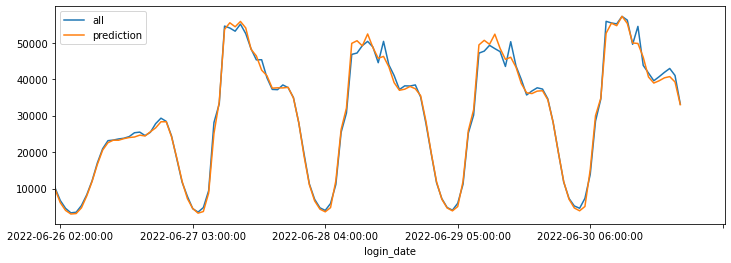

In [79]:
real_value.plot(figsize=(12, 4))
plt.xlim(49)

In [83]:
timeseries_evaluation_metrics_func(real_value["all"], real_value["prediction"])

Evaluation metric results:-
MSE is : 1764365.8447719337
MAE is : 935.308605375744
RMSE is : 1328.2943366482948
MAPE is : 4.469036094644701
R2 is : 0.9930726748652409

